In [116]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

<h1>Utgangspunkt for undersøkelsen</h1>

<p>Undersøkelsen tar utgangspunkt i data hentet fra nettsiden til Motor (https://www.motor.no/aktuelt/motors-store-vintertest-av-rekkevidde-pa-elbiler/217132), som presenterer resultater fra en vintertest av rekkevidde for ulike elbilmodeller. Formålet var å analysere hvordan faktisk kjørt distanse (Kjørt (km)) i kalde forhold (0° til -10°C) avviker fra de oppgitte WLTP-verdiene (Worldwide Harmonized Light Vehicles Test Procedure) som leverandørene oppgir. Dataene ble hentet ved hjelp av webscraping med Python-biblioteker som requests og BeautifulSoup, og deretter strukturert i en Pandas DataFrame for videre analyse. De største utfordringene i prosessen inkluderte en ødelagt lenke i utgangspunktet, samt problemer med kolonnenavn som inneholdt unødvendige mellomrom, noe som krevde manuell rensing.
Funn

 Datahåndtering: Etter rensing ble dataene strukturert med kolonner for modellnavn, WLTP-verdier (km og kWh), faktisk kjørt distanse (Kjørt (km)), og avvik i prosent (Avvik (%)). En ny kolonne, "Forhold Kjørt/WLTP", ble beregnet som forholdet mellom faktisk kjørt distanse og WLTP-km for å kvantifisere hvor nær bilene kom til de oppgitte verdiene.

Kolonnen "Forhold Kjørt/WLTP" (punkt 3 i koden) representerer forholdet mellom faktisk kjørt distanse og WLTP-km, mens "Avvik (%)" viser prosentvis avvik fra WLTP-verdien.
For eksempel så kan det sjekkes med matematiske beregninger at en sammenhengen er "Forhold Kjørt/WLTP" = 0.85, blir "Avvik (%)" = (0.85 - 1) × 100 = -15%, noe som stemmer med dataene. Dermed bekrefter de to kolonnene hverandre.</p>
<h4> Regresjonsanalyse</h4>
<p>En lineær regresjonsmodell ble tilpasset dataene, med WLTP-km som uavhengig variabel (x) og Kjørt (km) som avhengig variabel (y). Modellen ga ligningen f(x)=0.87x−26.65f(x)=0.87x−26.65, som indikerer at faktisk rekkevidde i snitt er lavere enn WLTP-verdiene. Stigningstallet på 0.87 viser at for hver kilometer WLTP-rekkevidde oppnås omtrent 87% av distansen i praksis under testforholdene, mens det negative skjæringspunktet antyder en systematisk underprestasjon som blir tydeligere ved lavere WLTP-verdier.</p>

<h4>Visualisering:</h4>
<p>To plott ble generert: ett basert på dataenes spenn og ett som inkluderer origo. Begge viser faktiske data mot regresjonslinjen og leverandørens påstand (y = x).</p>

<h4>Er konklusjonen av plottene fra punkt 5 et tilfelle av tukling med y-aksen?</h4>
<p>Nei, konklusjonen fra plottene er ikke et resultat av tukling med y-aksen. Begge plottene (med og uten origo) viser forholdet mellom WLTP-km og Kjørt (km) på en konsistent måte, med y-aksen som representerer faktisk kjørt distanse. Forskjellen mellom variantene ligger i x-aksens spenn:

-  Variant 1 (uten origo) fokuserer på dataenes faktiske område (320–645 km), noe som gir en mer detaljert fremstilling av avvikene.
- Variant 2 (med origo) strekker x-aksen til 0, noe som kan gi inntrykk av større avvik visuelt, men y-aksen er ikke manipulert.
    
Regresjonslinjen og leverandørens påstand (y = x) er korrekt plottet i begge tilfeller, og avviket fra y = x-linjen reflekterer reelle data.</p>

<h4>Kan vi med tilstrekkelig grad av sannsynlighet påstå at leverandørene holder det de lover?</h4>
<p>Nei, basert på dataene kan vi ikke med tilstrekkelig grad av sannsynlighet påstå at leverandørene holder det de lover under disse testforholdene. Regresjonsmodellen viser en stigning på ca. 0.79, noe som betyr at for hver kilometer WLTP-rekkevidde oppnås kun ca. 79% av distansen i praksis. Alle biler i testen hadde negativt avvik (fra -11% til -31.83%), og ingen nådde eller oversteg WLTP-verdien. Dette indikerer at WLTP-verdiene systematisk overvurderer rekkevidden i vinterforhold. Selv om WLTP er en standardisert test under kontrollerte forhold, antyder resultatene at leverandørene ikke fullt ut lever opp til løftene sine i realistiske, kalde scenarier.</p>

<h4>Gjennomsnittlig avvik for alle bilene i testen</h4>
<p>Gjennomsnittlig avvik kan beregnes fra kolonnen "Avvik (%)".

Basert på dataene er gjennomsnittlig avvik ca. -19.07% (summen av avvikene divideres med antall biler, 31). Dette bekrefter at bilene i snitt oppnådde 19.07% kortere rekkevidde enn WLTP-verdiene, noe som understreker en betydelig forskjell mellom løfte og prestasjon i testen.</p>

<h4>Konklusjon</h4>
<p>Undersøkelsen viser at faktisk rekkevidde for elbiler i vinterforhold konsekvent ligger under WLTP-verdiene, med et gjennomsnittlig avvik på -19.07%. Forholdet Kjørt/WLTP og Avvik (%) bekrefter dette matematisk, regresjonsanalysen underbygger trenden, og plottene gir en ærlig visuell fremstilling uten manipulasjon. Resultatene tyder på at leverandørene ikke holder løftene sine under disse betingelsene, noe som kan være viktig informasjon for forbrukere i kalde klimaer.</p>

In [117]:
# Definerer en funksjon som henter HTML-tabeller fra en gitt URL
def fetch_html_tables(url):
    """Returns a list of tables in the html of url"""
    
    # Sender en HTTP GET-forespørsel til URL-en og lagrer responsen
    page = requests.get(url)
    
    # Parser HTML-innholdet fra responsen ved hjelp av BeautifulSoup
    bs = BeautifulSoup(page.content, "html.parser")  # Add "html.parser"
    
    # Finner alle <table>-elementer i den parsede HTML-en
    tables = bs.find_all('table')
    
    # Returnerer listen over tabeller funnet i HTML-en
    return tables
# Definerer en funksjon som konverterer en HTML-tabell til en liste
def html_to_table(html):
    """Returns the table defined in html as a list"""
    
    # Initialiserer en tom liste for å lagre tabellens rader
    table = []
    
    # Itererer over alle <tr>-elementer (rader) i HTML-tabellen
    for row in html.find_all('tr'):
        
        # Initialiserer en tom liste for å lagre cellene i raden
        r = []
        
        # Finner alle <td>-elementer (celler) i raden
        cells = row.find_all('td')
        
        # Itererer over hver celle i raden
        for cell in cells:
            
            # Formaterer cellens innhold og legger det til i raden
            cell = format(cell)
            r.append(cell)
        
        # Legger den ferdige raden til i tabellen
        table.append(r)
    
    # Returnerer den ferdige tabellen som en liste av lister
    return table
# Definerer en funksjon som formaterer innholdet i en celle
def format(cell):
    """Returns a string after converting bs4 object cell to clean text"""
    
    # Hvis cellen ikke har noe innhold, henter vi tekstinnholdet
    if cell.contents is None:
        s = cell.text
    
    # Hvis cellen har tomt innhold, returnerer vi en tom streng
    elif len(cell.contents) == 0:
        return ''
    
    # Ellers konverterer vi innholdet til en streng og slår det sammen
    else:
        s = ' '.join([str(c) for c in cell.contents])
    
    # Fjerner 'x' og linjeskift fra strengen
    s = s.replace('x', '')
    s = s.replace('\n', '')
    
    # Returnerer den rensede strengen
    return s
# URL til nettsiden som inneholder tabellen vi ønsker å hente
url = "https://www.motor.no/aktuelt/motors-store-vintertest-av-rekkevidde-pa-elbiler/217132"
# Henter alle HTML-tabeller fra den angitte URL-en
tables = fetch_html_tables(url)
# Velger den første tabellen fra listen over tabeller
table_html = tables[0]
# Konverterer HTML-tabellen til en liste
table = html_to_table(table_html)
# Ekstraherer overskrifter og data fra tabellen
head = table[0]
data = table[1:]
# Oppretter en pandas DataFrame med data og kolonneoverskrifter
df = pd.DataFrame(data, columns = head)
# Viser kolonnenavnene i DataFrame
df.columns

Index(['                Modell (temp. varierte fra 0° til -10°)                ',
       '                WLTP-tall                ',
       '                STOPP                ',
       '                Avvik                '],
      dtype='object')

In [118]:
# 2
# Del WLTP-tall kolonnen i to separate kolonner, 'WLTP_km' og 'WLTP_kWh', ved å splitte innholdet på '/'
df[['WLTP_km', 'WLTP_kWh']] = df['                WLTP-tall                '].str.split('/', expand=True)
# Rens verdiene i 'WLTP_km' kolonnen ved å erstatte komma med punktum, fjerne ' km', og konvertere til float
df['WLTP_km'] = df['WLTP_km'].str.replace(',', '.').str.replace(' km', '').astype(float)
# Rens verdiene i 'WLTP_kWh' kolonnen ved å erstatte komma med punktum, fjerne ' kWh', og konvertere til float
df['WLTP_kWh'] = df['WLTP_kWh'].str.replace(',', '.').str.replace(' kWh', '').astype(float)
# Oppdater kolonneoverskriftene for å inkludere enheter og gjøre dem mer lesbare
df.rename(columns={
    '                Modell (temp. varierte fra 0° til -10°)                ': 'Modell',
    'WLTP_km': 'WLTP-km (km)',
    'WLTP_kWh': 'WLTP-energi (kWh)',
    '                STOPP                ': 'Kjørt (km)',
    '                Avvik                ': 'Avvik (%)'
}, inplace=True)
# Fjern rader som har manglende eller meningsløse verdier i de spesifiserte kolonnene
df = df.dropna(subset=['WLTP-km (km)', 'WLTP-energi (kWh)', 'Kjørt (km)'])
# Rens 'Avvik (%)' kolonnen ved å erstatte komma med punktum, fjerne prosenttegn, og konvertere til numerisk datatype
df['Avvik (%)'] = df['Avvik (%)'].str.replace(',', '.').str.strip().str.replace('%', '')
df['Avvik (%)'] = pd.to_numeric(df['Avvik (%)'], errors='coerce')
# Fjern rader med NaN-verdier i 'Avvik (%)' kolonnen etter konvertering
df = df.dropna(subset=['Avvik (%)'])
# Vis det rensede datasettet
print(df)

                             Modell                 WLTP-tall                  \
0       Tesla Model 3 LR Dual motor                           614 km/14,7 kWh   
1      Mercedes-Benz EQS 580 4matic                           645 km/18,3 kWh   
2                    BMW iX Drive50                           591 km/21,4 kWh   
3       Tesla Model Y LR Dual motor                           507 km/16,9 kWh   
4             Volkswagen ID.3 PRO S                           539 km/16,3 kWh   
5                       Kia EV6 2WD                           528 km/16,5 kWh   
6                NIO ES8 LR 7-seter                           488 km/21,5 kWh   
7                       Kia EV6 4WD                           484 km/18,0 kWh   
8               Volkswagen ID.4 Pro                           485 km/18,4 kWh   
9               Hyundai Ioniq 5 2WD                           481 km/16,8 kWh   
10                       BMW i4 M50                           497 km/19,0 kWh   
11                Skoda Enya

In [119]:
# 3
# Rens og konverter 'Kjørt (km)' til numerisk format
df['Kjørt (km)'] = df['Kjørt (km)'].str.replace(' km', '').str.replace(',', '.').astype(float)

# Lag ny kolonne for forholdet mellom Kjørt (km) og WLTP-km (km)
df['Forhold Kjørt/WLTP'] = df['Kjørt (km)'] / df['WLTP-km (km)']

print(df)

                             Modell                 WLTP-tall                  \
0       Tesla Model 3 LR Dual motor                           614 km/14,7 kWh   
1      Mercedes-Benz EQS 580 4matic                           645 km/18,3 kWh   
2                    BMW iX Drive50                           591 km/21,4 kWh   
3       Tesla Model Y LR Dual motor                           507 km/16,9 kWh   
4             Volkswagen ID.3 PRO S                           539 km/16,3 kWh   
5                       Kia EV6 2WD                           528 km/16,5 kWh   
6                NIO ES8 LR 7-seter                           488 km/21,5 kWh   
7                       Kia EV6 4WD                           484 km/18,0 kWh   
8               Volkswagen ID.4 Pro                           485 km/18,4 kWh   
9               Hyundai Ioniq 5 2WD                           481 km/16,8 kWh   
10                       BMW i4 M50                           497 km/19,0 kWh   
11                Skoda Enya

In [120]:
# 4 
# Lag en regresjonsmodell av formen f(x) = ax + b ved å bruke lineær regresjon
# Ekstraher verdiene for den uavhengige variabelen 'WLTP-km (km)' som en 2D-array
X = df[['WLTP-km (km)']].values  # Uavhengig variabel
# Ekstraher verdiene for den avhengige variabelen 'Kjørt (km)' som en 1D-array
y = df['Kjørt (km)'].values      # Avhengig variabel
# Initialiser en lineær regresjonsmodell
model = LinearRegression()
# Tren modellen ved å tilpasse den til dataene (X og y)
model.fit(X, y)
# Hent stigningstallet (koeffisienten) fra den trenede modellen
a = model.coef_[0]  # Stigningstall
# Hent skjæringspunktet (intercept) fra den trenede modellen
b = model.intercept_  # Skjæringspunkt
# Skriv ut den resulterende regresjonsmodellen i formatet f(x) = ax + b
print(f"Regresjonsmodell: f(x) = {a:.2f}x + {b:.2f}")

Regresjonsmodell: f(x) = 0.87x + -26.65


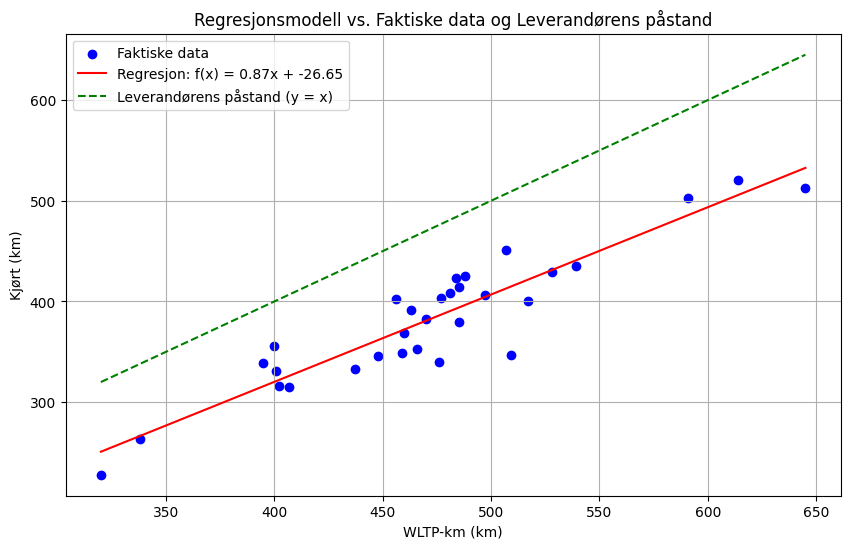

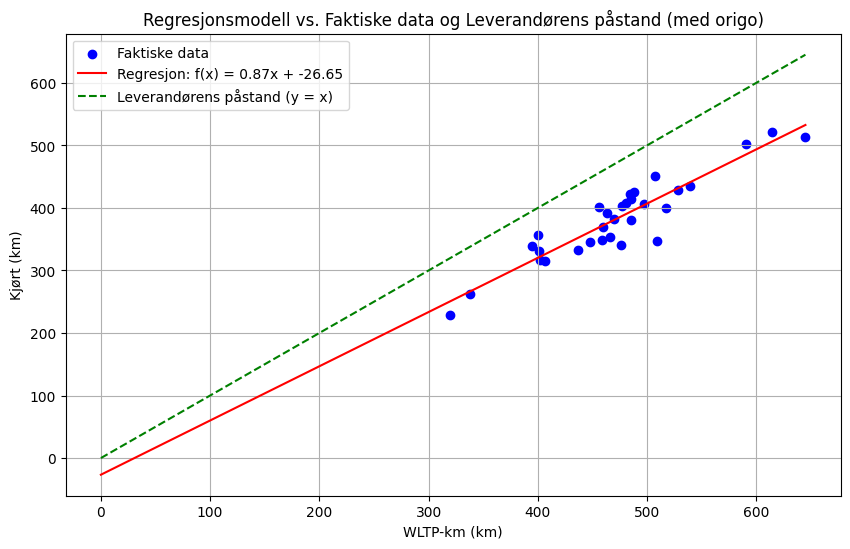

In [121]:
# 5: Plott modeller
# Variant 1: Visualiser regresjonsmodellen basert på dataenes x- og y-verdier
# Generer et spekter av x-verdier fra minimum til maksimum av 'WLTP-km (km)' med 100 punkter
x_range = np.linspace(df['WLTP-km (km)'].min(), df['WLTP-km (km)'].max(), 100)
# Beregn de predikerte y-verdiene ved hjelp av regresjonsmodellen for x_range
y_pred = model.predict(x_range.reshape(-1, 1))
# Opprett en figur for å plotte dataene
plt.figure(figsize=(10, 6))
# Plot de faktiske dataene som blå punkter
plt.scatter(df['WLTP-km (km)'], df['Kjørt (km)'], color='blue', label='Faktiske data')
# Plot regresjonslinjen som en rød linje
plt.plot(x_range, y_pred, color='red', label=f'Regresjon: f(x) = {a:.2f}x + {b:.2f}')
# Plot en grønn stiplet linje som representerer y = x (leverandørens påstand)
plt.plot(x_range, x_range, color='green', linestyle='--', label='Leverandørens påstand (y = x)')
# Sett etiketter for x- og y-aksene
plt.xlabel('WLTP-km (km)')
plt.ylabel('Kjørt (km)')
# Sett tittelen på plottet
plt.title('Regresjonsmodell vs. Faktiske data og Leverandørens påstand')
# Legg til en legende for å identifisere de ulike linjene og punktene
plt.legend()
# Aktiver rutenett for bedre lesbarhet
plt.grid(True)
# Vis plottet
plt.show()
# Variant 2: Visualiser regresjonsmodellen inkludert origo
# Generer et spekter av x-verdier fra 0 til maksimum av 'WLTP-km (km)' med 100 punkter
x_range_with_origin = np.linspace(0, df['WLTP-km (km)'].max(), 100)
# Beregn de predikerte y-verdiene ved hjelp av regresjonsmodellen for x_range_with_origin
y_pred_with_origin = model.predict(x_range_with_origin.reshape(-1, 1))
# Opprett en ny figur for å plotte dataene inkludert origo
plt.figure(figsize=(10, 6))
# Plot de faktiske dataene som blå punkter
plt.scatter(df['WLTP-km (km)'], df['Kjørt (km)'], color='blue', label='Faktiske data')
# Plot regresjonslinjen som en rød linje
plt.plot(x_range_with_origin, y_pred_with_origin, color='red', label=f'Regresjon: f(x) = {a:.2f}x + {b:.2f}')
# Plot en grønn stiplet linje som representerer y = x (leverandørens påstand)
plt.plot(x_range_with_origin, x_range_with_origin, color='green', linestyle='--', label='Leverandørens påstand (y = x)')
# Sett etiketter for x- og y-aksene
plt.xlabel('WLTP-km (km)')
plt.ylabel('Kjørt (km)')
# Sett tittelen på plottet
plt.title('Regresjonsmodell vs. Faktiske data og Leverandørens påstand (med origo)')
# Legg til en legende for å identifisere de ulike linjene og punktene
plt.legend()
# Aktiver rutenett for bedre lesbarhet
plt.grid(True)
# Vis plottet
plt.show()

In [122]:
# Beregn gjennomsnittet av 'Avvik (%)' kolonnen i DataFrame
gjennomsnittlig_avvik = df['Avvik (%)'].mean()
# Skriv ut det beregnede gjennomsnittlige avviket med to desimaler
print(f"Gjennomsnittlig avvik: {gjennomsnittlig_avvik:.2f}%")

Gjennomsnittlig avvik: -19.07%
